In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import AveragePooling1D, Activation, Flatten, Dense
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers import GlobalAveragePooling1D, UpSampling1D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import SGD, Adam, Nadam, Adamax
from sep_conv import concatmodel
from data_in import data_in, normali
#from autoencoder import autoencoder
#from tqdm import tqdm
#from sklearn.model_selection import train_test_split

/Users/xufanxiong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
X_train, y_train = data_in()

In [3]:
xmax = np.amax(X_train, axis=1, keepdims=True)
xmin = np.amin(X_train, axis=1, keepdims=True)

In [4]:
x_aaa = xmax - xmin

In [5]:
X_train = X_train/x_aaa

In [6]:
#Nomalization
y_train = (y_train-50)/150
#X_train = normali(X_train)
print('Shape of X_train is: ' + str(X_train.shape))
print('Shape of y_train is: ' + str(y_train.shape))

Shape of X_train is: (1768, 1000, 5)
Shape of y_train is: (1768, 1)


In [7]:
X_train_PPG = X_train[:, :, :2]
X_train_acc = X_train[:, :, 2:]

Heart rate is: [155.60165975]


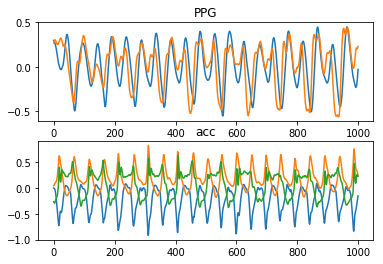

In [10]:
num_in = 1000
print('Heart rate is: ' + str(y_train[num_in]*150+50))
plt.subplot(211)
plt.plot(X_train_PPG[num_in, :, :])
plt.title('PPG')
plt.subplot(212)
plt.plot(X_train_acc[num_in, :, :])
plt.title('acc')
plt.show()

In [11]:
#Add Gaussian Noise
sigma = 0.0005
mu = 0
noise = np.random.randn(X_train_PPG.shape[0], X_train_PPG.shape[1], X_train_PPG.shape[2])*sigma + mu
#noise[:, :, 2:5] = 0
X_train_PPG_noise = X_train_PPG + noise
X_train_PPG_noise = X_train_PPG_noise / (X_train_PPG_noise.max() - X_train_PPG_noise.min())

Heart rate is: [79.5990566]


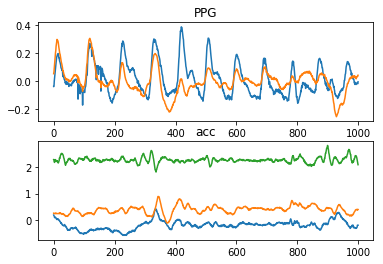

In [12]:
num_in = 10
print('Heart rate is: ' + str(y_train[num_in]*150+50))
plt.subplot(211)
plt.plot(X_train_PPG_noise[num_in, :, :])
plt.title('PPG')
plt.subplot(212)
plt.plot(X_train_acc[num_in, :, :])
plt.title('acc')
plt.show()

In [13]:
final_model = concatmodel((1000, 3), (1000,2), 8)

/Users/xufanxiong/Desktop/Troika_1/sep_conv.py:281: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("dr...)`
  finalmodel = Model(input=[inputs_1, inputs_2], output=final_layer)


In [14]:
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 3)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1000, 2)      0                                            
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 1000, 3)      0           input_1[0][0]                    
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 1000, 2)      0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (

In [17]:
optm = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=3*10**(-4))
final_model.compile(loss= "mse", 
              optimizer=optm, 
              metrics=["mse"])

In [18]:
filepath="weight_troika_sep_model_concatenate.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_mean_squared_error', 
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]
history = final_model.fit([X_train[:, :, 2:], X_train[:, :, :2]], y_train, 
                    epochs=100, 
                    batch_size=128, 
                    validation_split=0.2, 
                    callbacks=callbacks_list,
                    shuffle=True,
                    verbose=1)

Train on 1414 samples, validate on 354 samples
Epoch 1/100
1414/1414 [==============================] - 102s 72ms/step - loss: 0.9137 - mean_squared_error: 0.0926 - val_loss: 0.8744 - val_mean_squared_error: 0.0533

Epoch 00001: val_mean_squared_error improved from inf to 0.05332, saving model to weight_troika_sep_model_concatenate.hdf5
Epoch 2/100
1414/1414 [==============================] - 95s 67ms/step - loss: 0.9090 - mean_squared_error: 0.0880 - val_loss: 0.8740 - val_mean_squared_error: 0.0532

Epoch 00002: val_mean_squared_error improved from 0.05332 to 0.05316, saving model to weight_troika_sep_model_concatenate.hdf5
Epoch 3/100
 640/1414 [============>.................] - ETA: 50s - loss: 0.9166 - mean_squared_error: 0.0957

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
final_model.load_weights('weight_troika_sep_model_concatenate.hdf5')

In [ ]:
#Evaluate
#eva = finalmodel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
#print('loss = ' + str(eva[0]))
#print('Test MSE = ' + str(eva[1]))

In [ ]:
#Import Test
X_test = sio.loadmat('Training_data/DATA_12_TYPE02.mat')
y_test = sio.loadmat('Training_data/DATA_12_TYPE02_BPMtrace.mat')
X_test = X_test['sig'].T
y_test = y_test['BPM0']
X_test = X_test[:, 1:]
print('The shape of X_test is: ' + str(X_test.shape))
print('The shape of y_test is: ' + str(y_test.shape))

In [ ]:
#Split data
tem = X_test
X_test = np.zeros((y_test.shape[0], 125*8, 5))
k = 0

for i in range(y_test.shape[0]):
    X_test[i, :, :] = tem[k:(k+125*8), :]
    k += 2*125
    
tem = 0
print('The shape of X_test is: ' + str(X_test.shape))

In [ ]:
X_test = normali(X_test)
y_test = (y_test - 50)/150

In [ ]:
predict = final_model.predict([X_test[:, :, 2:], X_test[:, :, :2]])

In [ ]:
plt.plot(y_test)
plt.plot(predict)